# Importing Libraries

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# Data Loading and Exploration

In [2]:
train_df = pd.read_csv("bean-leaf-dataset/train.csv")
val_df = pd.read_csv("bean-leaf-dataset/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "bean-leaf-dataset/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,bean-leaf-dataset/train/healthy/healthy_train....,0
1,bean-leaf-dataset/train/healthy/healthy_train....,0
2,bean-leaf-dataset/train/healthy/healthy_train....,0
3,bean-leaf-dataset/train/healthy/healthy_train....,0
4,bean-leaf-dataset/train/healthy/healthy_train....,0


In [3]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# Data Spliting

In [4]:
train=data_df.sample(frac=0.7,random_state=7) 
test=data_df.drop(train.index) 

# Preprocessing Objects

In [5]:
label_encoder = LabelEncoder() 

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), 
    transforms.ConvertImageDtype(torch.float),
    ])

# Custom Class Dataset

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

#### Dataset Objects

In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# Visualize sample images

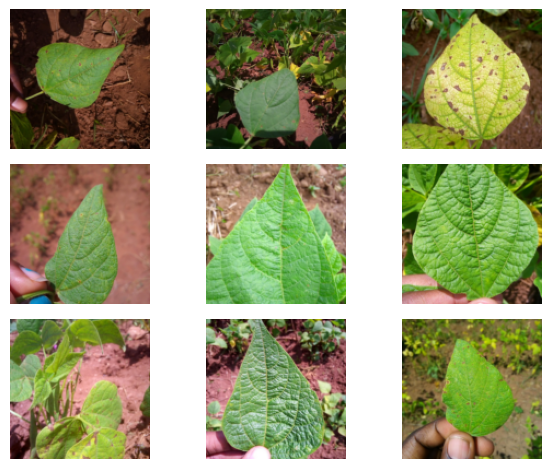

In [8]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

# Hyperparameters

In [9]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

### DataLoader

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Tansfer Learning on Googlenet Model

In [11]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [12]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [13]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Loss and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

# Training 

In [15]:

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/15, Train Loss: 1.8969 Train Accuracy 56.5483%

Epoch 2/15, Train Loss: 1.7721 Train Accuracy 61.5667%

Epoch 3/15, Train Loss: 1.6073 Train Accuracy 66.0955%

Epoch 4/15, Train Loss: 1.5157 Train Accuracy 67.9315%

Epoch 5/15, Train Loss: 1.4344 Train Accuracy 70.257%

Epoch 6/15, Train Loss: 1.4179 Train Accuracy 70.7466%

Epoch 7/15, Train Loss: 1.2929 Train Accuracy 73.0722%

Epoch 8/15, Train Loss: 1.2004 Train Accuracy 77.3562%

Epoch 9/15, Train Loss: 1.1015 Train Accuracy 79.0698%

Epoch 10/15, Train Loss: 1.14 Train Accuracy 77.7234%

Epoch 11/15, Train Loss: 1.0115 Train Accuracy 79.8042%

Epoch 12/15, Train Loss: 1.0556 Train Accuracy 79.8042%

Epoch 13/15, Train Loss: 0.9525 Train Accuracy 83.5985%

Epoch 14/15, Train Loss: 0.7741 Train Accuracy 86.0465%

Epoch 15/15, Train Loss: 0.846 Train Accuracy 84.7001%



# Visualization

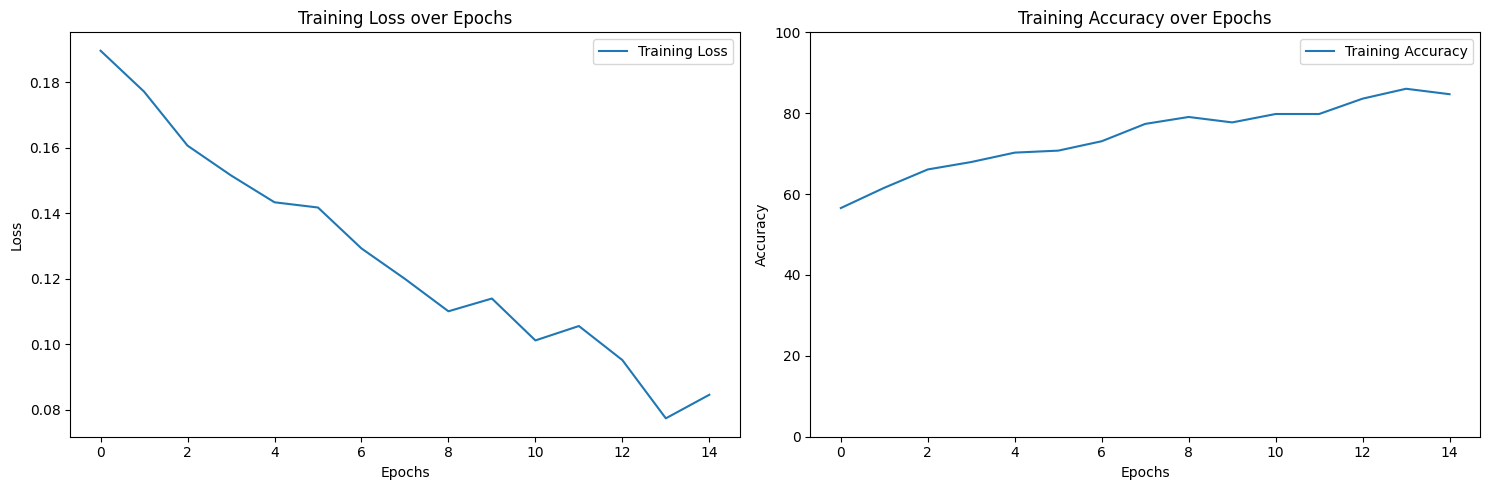

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

# Testing and Evaluation

In [18]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 79.71%
